In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.stats import norm
import pickle
# allows currency formatting
import locale
locale.setlocale(locale.LC_ALL, 'en_CA.UTF-8')
%matplotlib inline
style.use('ggplot')

In [598]:
pwd

'/Users/flatironschool/UrPortfolio/recommendation_system'

In [5]:
cluster_rec = pd.read_csv('clusters_rec.csv')

In [70]:
risks = input('input your risk: ')
prices = input('Average amount willing to spend on a stock: ')
prices = float(prices)
risks = float(risks)/100
jj = cluster_rec[cluster_rec['yr_variance'] <= risks]
jj = jj[jj['Price'] <= prices]
jj = jj[jj['sharpe_ratio'] >= 0]
jj.sort_values('sharpe_ratio', ascending = True)
stocking = int(jj.iloc[0][0])
#testing trial
rec_comp_main = jj.drop(columns ='Unnamed: 0')
rec_test = rec_comp_main.drop(columns = ['symbol','company','sector'])
pip = rec_test
pip = pip.index[0]

input your risk: 30
Average amount willing to spend on a stock: 100


In [47]:
risks

0.3

### Scale the Data

In [63]:
scaler = StandardScaler()
scaler.fit(rec_test)
# save the model to disk
filename = 'scaler.pickle'
pickle.dump(scaler, open(filename, 'wb'))

### Fit the Model

In [64]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm= 'brute')
model_knn.fit(rec_test)
filename_knn = 'model_knn.pickle'
pickle.dump(model_knn, open(filename_knn, 'wb'))

In [ ]:
# Function script running Model

### KNN closes related stock

In [71]:
# Input the stock number 
test = [stocking]
dftest = rec_test.iloc[test,:]
distances, indices = model_knn.kneighbors(rec_test, n_neighbors= 50)
stock = pd.DataFrame(indices.T)[test]
stock = stock.set_index(test)
stock = stock.merge(rec_comp_main, left_index = True, right_index = True)
testing_2 = stock

In [72]:
testing_2

,symbol,avg_yr_returns,yr_variance,sharpe_ratio,cluster,Price,company,sector
5,ABC,0.208920,0.299250,0.115628,0,74.089996,AbbVie Inc.,Healthcare
44,AME,0.220707,0.280838,0.121299,10,28.523600,"Advanced Micro Devices, Inc.",Technology
8,ACC,0.154778,0.295026,0.060151,0,79.415001,Abbott Laboratories,Healthcare
56,APD,0.158804,0.271867,0.056117,0,20.525000,Apache Corporation,Basic Materials
108,CF,0.128420,0.265070,0.023099,11,33.049999,"CF Industries Holdings, Inc.",Basic Materials


### Recommender System best fit stock

In [52]:
inpt_idx = pip
inpt = rec_test.iloc[inpt_idx]
scores = pd.Series(index=rec_test.index)
scores.iloc[inpt_idx] = -1
for idx, stock in rec_test.drop(index=inpt_idx).iterrows():
    diff = 0
    for feature in stock.index:
        diff += (inpt.loc[feature]-stock.loc[feature])**2
    scores.loc[idx] = diff
scores.sort_values()
scores = pd.DataFrame(scores.sort_values())
recommend_err = scores.merge(rec_comp_main, left_index = True, right_index = True)
recommend_err = recommend_err.rename({0: 'RMSE'}, axis = 1)
testing = recommend_err.head(10)

In [53]:
testing

,RMSE,symbol,avg_yr_returns,yr_variance,sharpe_ratio,cluster,Price,company,sector
11,0.000000,ACN,0.197221,0.299085,0.103878,0,36.450001,AECOM,Services
319,0.354687,LRCX,0.184756,0.284616,0.086668,0,35.855000,Eli Lilly and Company,Healthcare
498,1.217340,TROW,0.139829,0.284915,0.041844,0,37.549999,Sysco Corporation,Services
282,4.849819,IT,0.172205,0.290998,0.076268,0,38.651901,Intuit Inc.,Technology
220,5.677345,NWS,0.184925,0.286804,0.087585,0,38.832600,First Trust New Opportunities MLP & Energy Fund,Financial
355,33.930729,MTB,0.192034,0.294283,0.097168,0,42.275002,Monster Beverage Corporation,Consumer Goods
434,35.702453,RCL,0.177139,0.274411,0.075403,0,30.475000,"PPG Industries, Inc.",Basic Materials
529,95.759926,VNO,0.194407,0.194678,0.051005,0,26.665001,UnitedHealth Group Incorporated,Healthcare
374,124.995736,NLSN,0.191723,0.247379,0.078870,0,47.630001,Nabors Industries Ltd.,Basic Materials
15,126.424987,ADP,0.118783,0.242691,0.003750,11,38.775002,Archer-Daniels-Midland Company,Consumer Goods


#### Testing Part one

In [540]:
log_returns = np.log(1 + testing['avg_yr_returns'])
# testing[''].plot(figsize=(10, 6))
# plt.show()

In [136]:
u = testing['avg_yr_returns'].sum()
var = testing['yr_variance'].sum()
drift = u - (0.5 * var)
stdev = log_returns.std()

In [164]:
x = np.random.rand(10, 2)
Z = norm.ppf(np.random.rand(10,2))
t_intervals = 100
iterations = 10
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

In [171]:
testing['Price'].sum()

534.7349920272827

In [172]:
pd.DataFrame(np.e**daily_returns * 100)

,0,1,2,3,4,5,6,7,8,9
0,275.340745,276.523649,276.551109,281.405314,273.879525,280.865285,279.505934,283.514844,276.527208,278.751313
1,277.930690,284.988908,275.748258,279.856928,283.325903,282.955021,278.578152,276.656956,277.408610,277.744785
2,274.814052,279.751634,276.938170,276.908032,276.283882,278.932580,281.814310,277.635038,277.406390,281.427970
3,282.014824,276.102975,277.307941,275.584460,279.565033,278.592130,277.939667,279.707872,279.853822,276.157153
4,275.440108,277.515331,275.035728,278.394599,276.728886,275.355836,276.818664,276.878397,278.773008,277.138837
5,278.084428,274.912820,280.259944,278.212391,279.909466,279.590143,278.941751,280.130459,279.257827,283.303288
6,274.862878,280.899876,278.272872,279.338549,273.978404,277.040092,280.006050,272.596956,271.660734,278.771602
7,275.963040,275.946426,277.131963,279.725295,283.429735,276.030484,279.852186,275.903417,281.412602,276.899021
8,279.042270,280.102458,276.440035,276.590081,277.872282,276.563330,278.364098,282.881531,279.855889,278.664056
9,276.221650,278.780448,274.936499,280.865882,279.052907,273.035538,277.847780,271.471794,279.655027,276.428689


In [167]:
#stock price of today
S0 = testing['Price'].sum()

In [168]:
price_list = np.zeros_like(daily_returns)
price_list[0] = S0
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

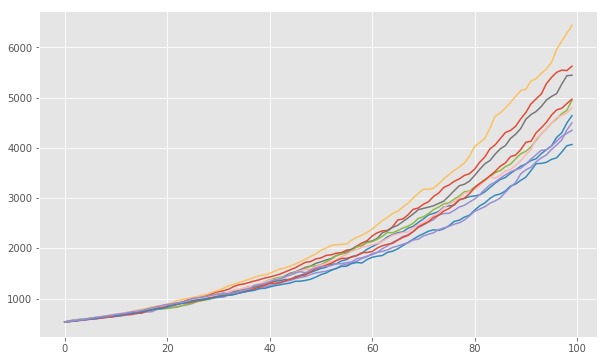

In [169]:
plt.figure(figsize=(10,6))
plt.plot(price_list)
plt.show()

#### Testing Part 2

In [54]:
price_per = float(testing['Price'].sum()) + 6
expected_return = float(testing['avg_yr_returns'].mean())
volatility = float(testing['yr_variance'].mean())
print(f'price per year : {price_per}')
print(f'expected return : {expected_return}')
print(f'risk : {volatility}')

price per year : 379.1595058441162
expected return : 0.17530214730326055
risk : 0.26998595202589426


In [56]:
# 4. Simulate portfolio ending market values 

sim = pd.DataFrame()
iterations = 5000


for x in range(iterations):
    pv = float(testing['Price'].sum()) + 6
    expected_return = float(testing['avg_yr_returns'].mean())
    volatility = float(testing['yr_variance'].mean())
    time_horizon = 5
    annual_investment = pv
    stream = []
    for i in range(time_horizon):
        end = round(pv * (1 + np.random.normal(expected_return,volatility)) + annual_investment,2)
        
        stream.append(end)

        pv = end

    
    sim[x] = stream

In [57]:
# 5. Sample first five streams of annual ending values
first_five = list(range(5))
sim[first_five]

,0,1,2,3,4
0,1099.17,762.97,886.62,704.68,755.59
1,1746.94,1113.88,1389.77,1231.76,1098.21
2,1073.59,1391.28,1593.30,2124.46,1718.90
3,2042.11,2303.76,2037.54,2639.71,2559.06
4,3010.59,2776.69,3343.72,4132.18,3166.16


In [58]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np


random_x = sim.index
random_y0 = sim[1]
random_y1 = sim[2]
random_y2 = sim[3]
random_y3 = sim[4]
random_y4 = sim[5]

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines+markers',
                    name='stream_1'))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines+markers',
                    name='stream_2'))
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='lines+markers', 
                    name='stream_3'))

fig.add_trace(go.Scatter(x=random_x, y=random_y3,
                    mode='lines+markers',
                    name='stream_4'))
fig.add_trace(go.Scatter(x=random_x, y=random_y4,
                    mode='lines+markers', 
                    name='stream_5'))

fig.show()

In [59]:
# 7. Generate summary statistics with numpy functions
amount = len(sim)-1
print("Count:", len(sim.loc[amount]))
print("Mean: ", locale.currency(np.mean(sim.loc[amount]),grouping=True))
print("SD: ",locale.currency(np.std(sim.loc[amount]),grouping=True))
print("Max: ",locale.currency(np.max(sim.loc[amount]), grouping=True))
print("Min: ", locale.currency(np.min(sim.loc[amount]), grouping=True))

Count: 5000
Mean:  $3,538.12
SD:  $1,183.63
Max:  $10,175.56
Min:  $704.50


In [60]:
#You can get a more comprehensive table of percentiles easily using numpy's percentile function
ending_values = sim.loc[amount]
p_tiles = np.percentile(ending_values,[5,10,15,25,50,75])
for p in range(len(p_tiles)):
    l = [5,10,15,25,50,75]
    print("{}%-ile:  ".format(l[p]).rjust(15),"{}".format(locale.currency(p_tiles[p], grouping=True)))
#     print(f"{l[p]}%-ile:  ",f"{locale.currency(p_tiles[p], grouping=True)}")

      5%-ile:   $1,903.00
     10%-ile:   $2,185.34
     15%-ile:   $2,377.44
     25%-ile:   $2,694.47
     50%-ile:   $3,363.76
     75%-ile:   $4,213.14


In [ ]:
# 3. Generating one possible future value based on market history; I will use 9% expected return with 18% volatility

pv = float(testing['Price'].sum()) + 6
expected_return = float(testing['avg_yr_returns'].mean())
volatility = float(testing['yr_variance'].mean())
time_horizon = 5
annual_addition = pv

print("\tReturn", "\t\tEnding Value".rjust(18))
for year in range(time_horizon):
    market_return = np.random.normal(expected_return, volatility)
    fv = pv * (1 + market_return) + annual_addition
    print("\t{}".ljust(10).format(round(market_return,4)), "\t{}".rjust(10).format(locale.currency(fv, grouping=True)))
    pv = fv